In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import random
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from parse_dataset import NetworkDataset, parse_dataset, split_datasets

In [12]:
conf = {
    "batch_size": 516,
    "epochs": 15,
    "learning_rate": 0.0001,
    "load_model": True
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# extract dataset from csv file
network_data_file = os.path.join(os.getcwd(), "datasets", "network_packet_data_test.csv")
data, labels, label_dict = parse_dataset(network_data_file)

# split dataset into train, val and test datasets
X_train, y_train, X_val, y_val, X_test, y_test = split_datasets(data, labels)
print(X_train.shape)
print(y_train.shape)

# create train, val and test dataloaders
train_dataset = NetworkDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=conf["batch_size"], shuffle=True)

val_dataset = NetworkDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=conf["batch_size"], shuffle=True)

test_dataset = NetworkDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=conf["batch_size"])

packet_dat,attack_cat

torch.Size([356334, 513])
torch.Size([356334])


In [4]:
data, labels = next(iter(train_loader))
print(data.shape, labels.shape)

torch.Size([516, 513]) torch.Size([516])


In [5]:
# create LSTM model:
class MLP(nn.Module):
    def __init__(self, size):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(size, 320),
            nn.BatchNorm1d(320),
            nn.ReLU(),
            nn.Dropout(p=0.10),

            nn.Linear(320, 24)
        )
    
    def forward(self, x):
        out = self.mlp(x)
        return out

In [6]:
model = MLP(X_train.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=conf["learning_rate"], weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)

if conf["load_model"]:
    # load model
    checkpoint_path = os.path.join(os.getcwd(), "checkpoint", "mlp_model.pth")

    checkpoint = torch.load(checkpoint_path, map_location=torch.device(device=device))

    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    epoch = checkpoint["epoch"]

    print(f"Checkpoint loaded from {checkpoint_path}, starting from epoch {epoch}")

In [7]:
# eval function
def evaluate(model, val_loader):
    y_true, y_pred = [], []

    model.eval()
    for (data, labels) in val_loader:
        if not data.is_cuda or not labels.is_cuda:
            data, labels = data.to(device), labels.to(device)
        
        with torch.no_grad():
            pred = model(data)
        
        y_true.append(labels)
        y_pred.append(pred)

    y_true, y_pred = torch.cat(y_true, dim=0), torch.cat(y_pred, dim=0)

    loss = criterion(y_pred, y_true)

    # evaluate accuracy

    acc = (y_pred.argmax(dim=1) == y_true).float().mean()

    return loss, acc

# training function
def train(model, train_loader, val_loader, epochs=conf["epochs"]):
    acc_list = []
    train_loss_list = []
    val_loss_list = []

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0

        # train model
        for (data, labels) in train_loader:
            if not data.is_cuda or not labels.is_cuda:
                data, labels = data.to(device), labels.to(device)

            pred = model(data)
            loss = criterion(pred, labels)
            running_loss += loss.item() * data.size(0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # evaluate model
        val_loss, acc = evaluate(model, val_loader)
        train_loss = running_loss / X_train.shape[0]
        scheduler.step()

        acc_list.append(acc)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
    
        print(f"Epoch: {epoch}/{epochs}, Accuracy: {100*acc:.2f}%, Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")

    return acc_list, train_loss_list, val_loss_list

# plot accuracy
def plot_data(data, type, title, n_epochs=conf["epochs"]):
    epochs = [epoch for epoch in range(1, n_epochs + 1)]
    data = [d.to('cpu') for d in data]
    plt.plot(epochs, data, marker="+", linestyle="dotted")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(type)
    plt.show()

Epoch: 1/15, Accuracy: 58.37%, Train loss: 1.9742, Val loss: 2.0231
Epoch: 2/15, Accuracy: 68.47%, Train loss: 1.2651, Val loss: 1.5800
Epoch: 3/15, Accuracy: 64.96%, Train loss: 1.0285, Val loss: 1.5135
Epoch: 4/15, Accuracy: 72.87%, Train loss: 0.9137, Val loss: 1.1713
Epoch: 5/15, Accuracy: 70.60%, Train loss: 0.8114, Val loss: 1.1646
Epoch: 6/15, Accuracy: 74.98%, Train loss: 0.7464, Val loss: 0.9732
Epoch: 7/15, Accuracy: 78.40%, Train loss: 0.7012, Val loss: 0.8280
Epoch: 8/15, Accuracy: 79.72%, Train loss: 0.6464, Val loss: 0.7801
Epoch: 9/15, Accuracy: 79.16%, Train loss: 0.6165, Val loss: 0.7718
Epoch: 10/15, Accuracy: 78.08%, Train loss: 0.5845, Val loss: 0.8035
Epoch: 11/15, Accuracy: 83.39%, Train loss: 0.5637, Val loss: 0.5951
Epoch: 12/15, Accuracy: 82.92%, Train loss: 0.5288, Val loss: 0.6857
Epoch: 13/15, Accuracy: 83.70%, Train loss: 0.5103, Val loss: 0.5645
Epoch: 14/15, Accuracy: 85.93%, Train loss: 0.4812, Val loss: 0.4956
Epoch: 15/15, Accuracy: 86.21%, Train loss:

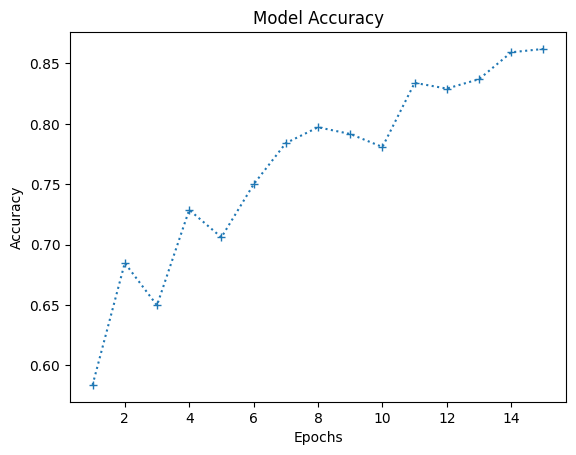

In [8]:
accuracy = []
train_loss = []
val_loss = []

if not conf["load_model"]:
    accuracy, train_loss, val_loss = train(model=model, train_loader=train_loader, val_loader=val_loader)
    plot_data(accuracy, type="Accuracy", title="Model Accuracy")

In [9]:
test_loss, test_acc = evaluate(model, test_loader)
print(f"Accuracy: {100*test_acc:.2f}%, Test loss: {test_loss:.4f}")

Accuracy: 85.95%, Test loss: 0.4916


In [10]:
def save_model(checkpoint_path, model, optimizer, scheduler):
    checkpoint = {
        "epoch": conf["epochs"],
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict()
    }

    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")

In [11]:
checkpoint_path = os.path.join(os.getcwd(), "checkpoint", "mlp_model.pth")
save_model(checkpoint_path, model, optimizer, scheduler)

Checkpoint saved at /home/jorgetf/testmodel/Network-Packet-ML-Model/checkpoint/mlp_model.pth
